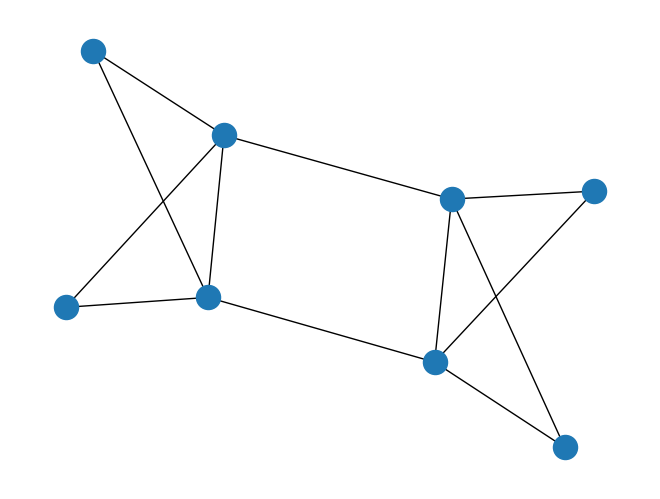

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
from utils import *


height = 2
width = 4
hidden_dim = 8


n_inputs = 2
n_outputs = 2


edges = build_edges(n_inputs, n_outputs, height, width)

n_nodes = height*width + n_inputs + n_outputs

type_dict = {"hidden": [1, 0, 0], "input": [0, 1, 0], "output": [0, 0, 1]}
total_hidden_dim = hidden_dim + len(type_dict["hidden"]) #hidden data + type
n_hidden_nodes = height*width


x = torch.zeros(n_nodes, total_hidden_dim)
data = Data(edge_index=edges, x=x)
graph = utils.to_networkx(data, to_undirected=True, remove_self_loops = True)
nx.draw(graph)


In [2]:
#Pytorch geometric graph classification
from torch_geometric.nn import GCNConv, Sequential
from torch.nn import ReLU, LeakyReLU


class UpdateRule(torch.nn.Module):
    def __init__(self, initial_dim, width = 16):
        super(UpdateRule, self).__init__()
        torch.manual_seed(12345)

        self.initial = nn.parameter.Parameter(torch.zeros(initial_dim))

        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.input_vectorizer = nn.Linear(n_inputs, total_hidden_dim, bias=True)
        
        # Vectorizes training targets
        self.reverse_output_vectorizer = nn.Linear(n_outputs, hidden_dim)
        
        self.output_vectorizer = nn.Linear(hidden_dim, 1)
        
        self.conv1 = GCNConv(total_hidden_dim, width)
        
        self.n_hidden_rule_layers = 1
        # self.hidden_rule_layers = Sequential('x, edge_index', 
        #                                      [x for i in range(n_hidden_rule_layers) for x in 
        #                                       [(GCNConv(width, width), 'x, edge_index -> x'), LeakyReLU(0.1, True)]])
        self.hidden_rule_layers = GCNConv(width, width)
        
        self.conv_out = GCNConv(width, hidden_dim)
        
        self.reset()

    def get_indices(self, x, type: str):
        return torch.argwhere((x[:,hidden_dim:] == torch.tensor(type_dict[type])).all(1)).squeeze(-1)
    
    def forward(self, x, edge_index, input_data):
        x = x.tanh()
        skip = x[:, hidden_dim:]
        
        #vectorize input
        mask = torch.zeros(x.shape)
        mask[(height*width):((height*width)+n_inputs)] = 1
        # print(mask)
        x = x+((self.input_vectorizer(input_data)-x) * mask)
        
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        
        for _ in range(self.n_hidden_rule_layers):
            x = self.hidden_rule_layers(x, edge_index)
            x = self.relu(x)
        
        x = self.conv_out(x, edge_index)
        x = torch.cat([x, skip], dim=-1)
        return x
    
    
    def get_output(self, x):
        """
        Returns last n_outputs nodes in x
        Args:
            x: Network state after rule application
        """
        
        output = self.output_vectorizer(x[-n_outputs:, :hidden_dim]).squeeze(-1)
        return output.softmax(-1)
        
    
    def reset(self):
        self.vectorized_input = None
        self.vectorized_output = None
        


In [3]:
from datasets import *

dataset_loader = DataLoader(XORDataset(), batch_size=1, shuffle=True)

update_rule = UpdateRule(data.x.shape)
optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)

losses = []
n_steps = 5
batch_size = 1
for epoch in range(1000):
    loss = 0
    for _ in range(batch_size):
        update_rule.reset() 
        
        batch_loss = 0
        x = update_rule.initial
        
        edge_index = data.edge_index.long().clone()
        
        for idx, (problem_data_x, problem_data_y) in enumerate(dataset_loader):
            for i in range(n_steps):
                output_node_data = torch.zeros(problem_data_y.shape)
                x = update_rule(x, edge_index, problem_data_x.float())
                
            
            network_output = update_rule.get_output(x)
            batch_loss += F.mse_loss(problem_data_y.float().squeeze(0), network_output)
            # break
         
        loss += batch_loss
    loss /= batch_size
    
    losses.append(loss.item())
    loss.backward()  
    optimizer.step()  
    optimizer.zero_grad()  
    print(f"\r Epoch {epoch * batch_size} | Loss {loss} | Network in: {problem_data_x}| Network out: {network_output} ", end="")
    
    if epoch % (100 // batch_size) == 0:
        print()


 Epoch 0 | Loss 1.0 | Network in: tensor([[1, 0]])| Network out: tensor([0.5000, 0.5000], grad_fn=<SoftmaxBackward0>) 
 Epoch 100 | Loss 0.9877590537071228 | Network in: tensor([[0, 0]])| Network out: tensor([0.5010, 0.4990], grad_fn=<SoftmaxBackward0>) 
 Epoch 151 | Loss 0.916089653968811 | Network in: tensor([[0, 1]])| Network out: tensor([0.4686, 0.5314], grad_fn=<SoftmaxBackward0>)  

KeyboardInterrupt: 

In [ ]:
import numpy as np
np.set_printoptions(precision=3)


def run_rule(data_x, update_rule, n_steps = 10):
    # x = data.x.float().clone()
    # x[x == -1] = torch.zeros(n_nodes * hidden_dim)
    x = update_rule.initial
    update_rule.reset()
    edge_index = data.edge_index.long().clone()
    for i in range(n_steps):
        x = update_rule(x, edge_index, data_x.float())
    
        network_output = update_rule.get_output(x)
        print(network_output)
    return network_output
    


run_rule(torch.tensor([[1,0]]), update_rule)

tensor([0.4898, 0.5102], grad_fn=<SoftmaxBackward0>)
tensor([0.4944, 0.5056], grad_fn=<SoftmaxBackward0>)
tensor([0.4920, 0.5080], grad_fn=<SoftmaxBackward0>)
tensor([0.4865, 0.5135], grad_fn=<SoftmaxBackward0>)
tensor([0.4842, 0.5158], grad_fn=<SoftmaxBackward0>)
tensor([0.4847, 0.5153], grad_fn=<SoftmaxBackward0>)
tensor([0.4852, 0.5148], grad_fn=<SoftmaxBackward0>)
tensor([0.4853, 0.5147], grad_fn=<SoftmaxBackward0>)
tensor([0.4850, 0.5150], grad_fn=<SoftmaxBackward0>)
tensor([0.4849, 0.5151], grad_fn=<SoftmaxBackward0>)


tensor([0.4849, 0.5151], grad_fn=<SoftmaxBackward0>)